In [1]:
from qulacs import Observable, QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

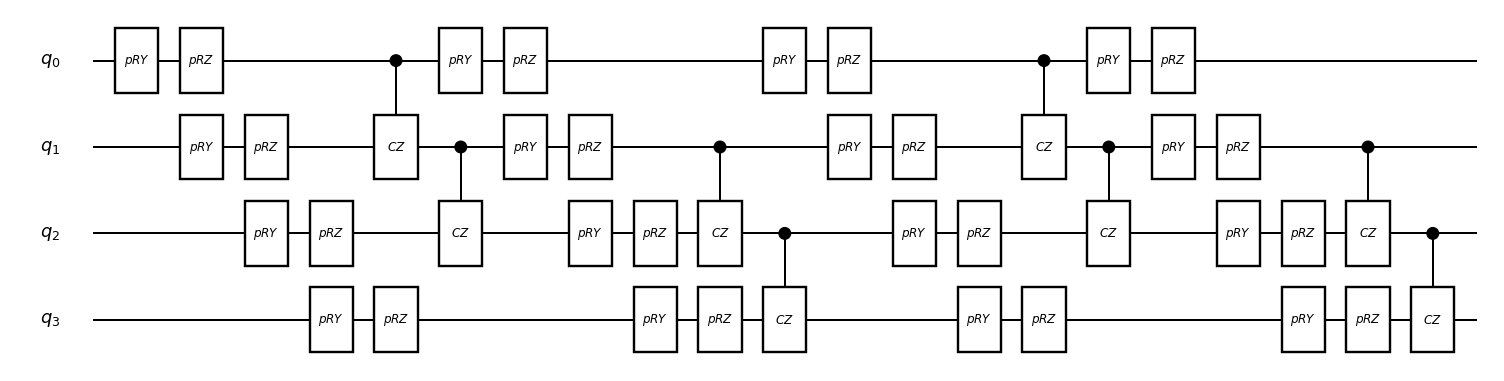

In [2]:
from qulacs import ParametricQuantumCircuit

n_qubits = 4
depth = 4
circuit = ParametricQuantumCircuit(n_qubits)
for d in range(depth):
    for i in range(n_qubits):
        circuit.add_parametric_RY_gate(i, 0.0)
        circuit.add_parametric_RZ_gate(i, 0.0)
    for i in range(n_qubits//2):
        circuit.add_CZ_gate((i+d%2)%n_qubits, (i+1+d%2)%n_qubits)

hamiltonian = Observable(n_qubits)
np.random.seed(1)
J_list = 2*np.random.rand(n_qubits)-1
for i in range(n_qubits):
    hamiltonian.add_operator(J_list[i], f"X {i} X {(i+1)%n_qubits}")
    hamiltonian.add_operator(J_list[i], f"Y {i} Y {(i+1)%n_qubits}")
    hamiltonian.add_operator(J_list[i], f"Z {i} Z {(i+1)%n_qubits}")

circuit_drawer(circuit, "mpl")

In [3]:
def get_cost(params):
    state = QuantumState(n_qubits)
    for i, p in enumerate(params):
        circuit.set_parameter(i, p)
    circuit.update_quantum_state(state)
    return hamiltonian.get_expectation_value(state)

In [4]:
def get_gradient_by_parameter_shift(params):
    grad_vector = np.zeros_like(params)
    tmp_params = np.copy(params)
    for i in range(len(params)):
        tmp_params[i] += np.pi/2
        plus = get_cost(tmp_params)
        tmp_params[i] -= np.pi
        minus = get_cost(tmp_params)
        grad_vector[i] = (plus-minus)/2
        tmp_params[i] = params[i]
    return grad_vector

In [5]:
def get_gradient_by_finite_diff(params, eps=1e-6):
    grad_vector = np.zeros_like(params)
    tmp_params = np.copy(params)
    for i in range(len(params)):
        tmp_params[i] += eps
        plus = get_cost(tmp_params)
        tmp_params[i] -= 2*eps
        minus = get_cost(tmp_params)
        grad_vector[i] = (plus-minus)/2/eps
        tmp_params[i] = params[i]
    return grad_vector

In [6]:
params = (2*np.random.random(circuit.get_parameter_count())-1)*np.pi
print(get_gradient_by_parameter_shift(params))
print(get_gradient_by_finite_diff(params))

[ 0.28641755 -0.00438154 -0.06712645 -0.32537361 -0.05751078  0.16557163
  0.11887725  0.10954547 -0.17033146 -0.24962483  0.12171529  0.35254303
 -0.39434455  0.16599231  0.2278707  -0.09372357  0.17685758  0.0195437
  0.02588595 -0.06820095  0.14981395 -0.43356911  0.27244975  0.25668482
  0.16067643 -0.02018968  0.70788171 -0.22227356 -0.03951543  0.43888274
 -0.20362175 -0.19641951]
[ 0.28641755 -0.00438154 -0.06712645 -0.32537361 -0.05751078  0.16557163
  0.11887725  0.10954547 -0.17033147 -0.24962483  0.12171529  0.35254303
 -0.39434455  0.16599231  0.2278707  -0.09372357  0.17685758  0.0195437
  0.02588595 -0.06820095  0.14981395 -0.43356911  0.27244975  0.25668482
  0.16067643 -0.02018968  0.70788171 -0.22227356 -0.03951543  0.43888274
 -0.20362175 -0.19641951]


In [7]:
from utility import get_matrix
from scipy.sparse.linalg import eigsh
eigvals = eigsh(get_matrix(hamiltonian), which="SR")[0]
print("ground state energy is:", min(eigvals))

ModuleNotFoundError: No module named 'utility'

In [8]:
n_steps = 1000
rate = 0.1
params = (2*np.random.random(circuit.get_parameter_count())-1)*np.pi
cost_history = np.zeros(n_steps)
for i in tqdm(range(n_steps)):
    params -= get_gradient_by_parameter_shift(params)*rate
    cost_history[i] = get_cost(params)

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 176.47it/s]


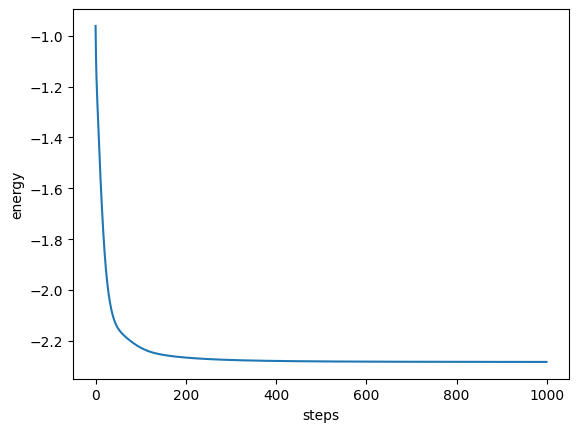

In [10]:
plt.plot(cost_history)
# plt.axhline(min(eigvals), color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("steps")
plt.show()

In [11]:
def sample_ZZ(state, _n_shots):
    global J_list
    samples = state.sampling(_n_shots)
    estimated_energy = 0
    mask_list = [0b0011, 0b0110, 0b1100, 0b1001]
    for s in samples:
        for J, mask in zip(J_list, mask_list):
            bitcount = bin(s & mask).count("1")
            estimated_energy += J*(-1)**bitcount/_n_shots
    return estimated_energy

from qulacs.gate import H, Sdag
def sample_XX(state, _n_shots):
    global J_list
    for i in range(n_qubits):
        H(i).update_quantum_state(state)
    samples = state.sampling(_n_shots)
    estimated_energy = 0
    mask_list = [0b0011, 0b0110, 0b1100, 0b1001]
    for s in samples:
        for J, mask in zip(J_list, mask_list):
            bitcount = bin(s & mask).count("1")
            estimated_energy += J*(-1)**bitcount/_n_shots
    return estimated_energy

def sample_YY(state, _n_shots):
    global J_list
    for i in range(n_qubits):
        Sdag(i).update_quantum_state(state)
        H(i).update_quantum_state(state)
    samples = state.sampling(_n_shots)
    estimated_energy = 0
    mask_list = [0b0011, 0b0110, 0b1100, 0b1001]
    for s in samples:
        for J, mask in zip(J_list, mask_list):
            bitcount = bin(s & mask).count("1")
            estimated_energy += J*(-1)**bitcount/_n_shots
    return estimated_energy

def sample_cost(params, n_shots=1000):
    state = QuantumState(n_qubits)
    for i, p in enumerate(params):
        circuit.set_parameter(i,p)
    circuit.update_quantum_state(state)
    return sample_ZZ(state, n_shots) + sample_XX(state, n_shots) + sample_YY(state, n_shots)

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 91.69it/s]


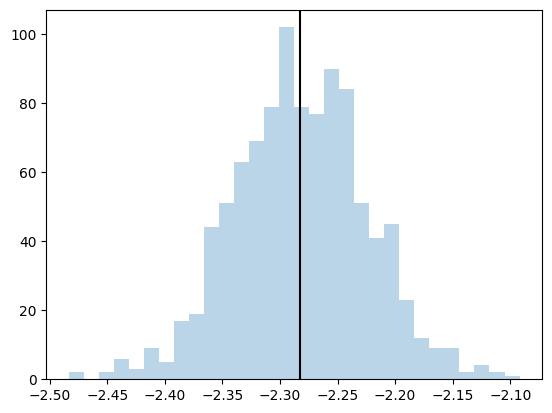

In [12]:
n_tests = 1000
costs = np.zeros(n_tests)
for i in tqdm(range(n_tests)):
    costs[i] = sample_cost(params)
plt.hist(costs, bins=30, alpha=0.3)
plt.axvline(get_cost(params), color="black")
plt.show()